<a href="https://colab.research.google.com/github/sandhrabijoy/Time-series/blob/main/time_series_forecasting2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SETUP

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['axes.grid']=False

The weather dataset

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
df=pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
#since data is in every 10 mins we convert to hourly,starting from index 5 we take every 6th record
df=df[5::6]


In [7]:
date_time=df['Date Time']

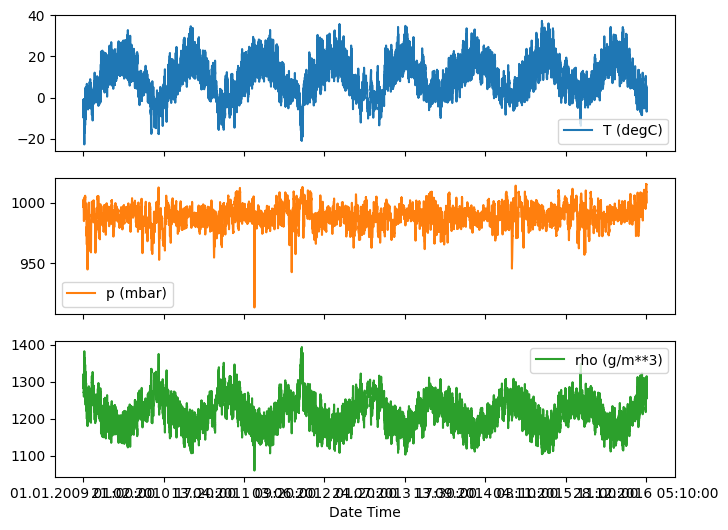

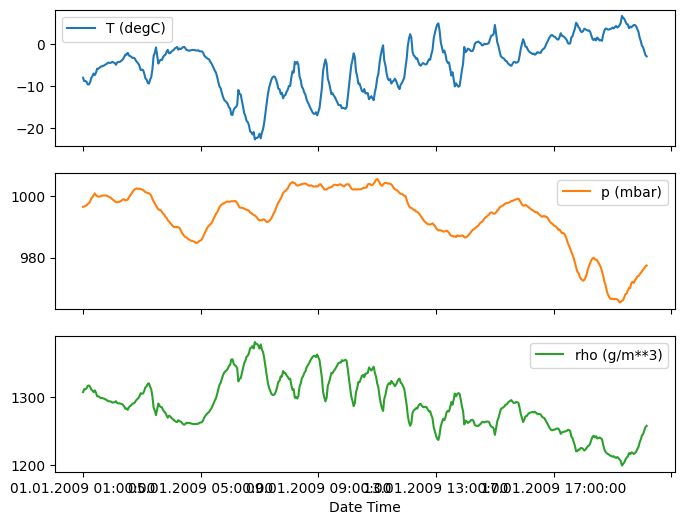

In [8]:
# plotting the evolution of features over time
plot_cols=['T (degC)','p (mbar)','rho (g/m**3)']

plot_features=df[plot_cols]
plot_features.index=date_time
_=plot_features.plot(subplots=True)

plot_features=df[plot_cols][:480]
plot_features.index=date_time[:480]
_=plot_features.plot(subplots=True)